# Progetto di Fondamenti dell'Elaborazione di Segnali e Immagini 
# TRASFORMAZIONI GEOMETRICHE
## Proiezione della targa di un auto

### Vella Mirco - 4803218


Nell'ambito delle trasformazioni geometriche ho cercato un problema reale sul quale costruire un caso di studio.
Il problema affrontato è quello appunto della proiezione di un immagine, con lo scopo di rendere, in questo particolare caso, la targa di una macchina più leggibile.

## Obiettivi

1. Zoomare la parte scelta, in quanto molto spesso la porzione da proiettare risultava troppo piccola, pertanto è    stato necessario ingrandirla, per facilitare anche la comprensione.


2. Proiettare la targa


3. Confrontare la qualità del risultato con quello ottenuto tramite OpenCV2



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage import data, io, color
from skimage.transform import rotate
from skimage import  exposure, img_as_float, img_as_ubyte 
import pylab as plt

from matplotlib.patches import Circle
import cv2

/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper
/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:293: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  plugin_module = __import__('skimage.io._plugins.' + modname,


(-0.5, 511.5, 511.5, -0.5)

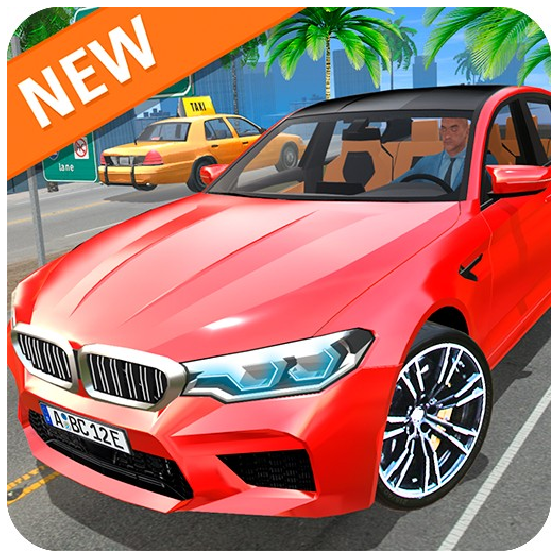

In [3]:
#LOAD IMAGE
img = plt.imread('images/car1.jpg')

plt.figure(figsize=(20,10))
plt.imshow(img); 
plt.axis('off')

## *Ho deciso di suddividere il problema in due parti:*
La divisione segue gli obiettivi stabiliti, ovvero:

1. Zoomare su una porzione scelta
2. Proiettare la porzione zoomata 

La prima funzione risulterà essere una composizione di isolamento, traslazione e scaling.
Di seguito vediamo le tre parti separate:

La funzione pick_part effettua l'isolamento di una porzione scelta tramite indici x1,x2,y1,y2.
Il risultato sarà dunque un immagine perlopiù nera ad eccezione della zona selezionata precedentemente. 
In questa funzione, come del resto in tutte le altre, ho usato un mapping inverso, per tanto andavo a mappare ogni pixel dell'immagine nuova con il corrispondente, o modificato, pixel dell'immagine originale.

In [4]:
def pick_part(image,x1,x2,y1,y2):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u
            y = v
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if x1 < x < x2 and y1 < y < y2:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

Text(0.5, 1.0, 'Choosen section:')

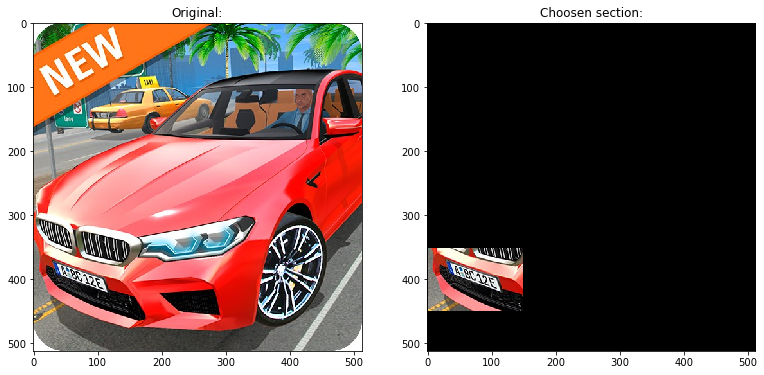

In [5]:
#TEST PICK_PART
#[y,x]
I_sectioned=pick_part(img, 350,450,0,150)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Original:')
plt.subplot(132)
plt.imshow(I_sectioned)
plt.title('Choosen section:')

La funzione partial_translate semplicemente trasla la porzione isolata nell'angolo in alto a sinistra, in modo da permettere il successivo scaling.

In [6]:
def partial_translate(image, x1,x2,y1,y2, t):
    width,height=image.shape[:2]    
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u-t[0]
            y = v-t[1]
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

Text(0.5, 1.0, 'Traslated section:')

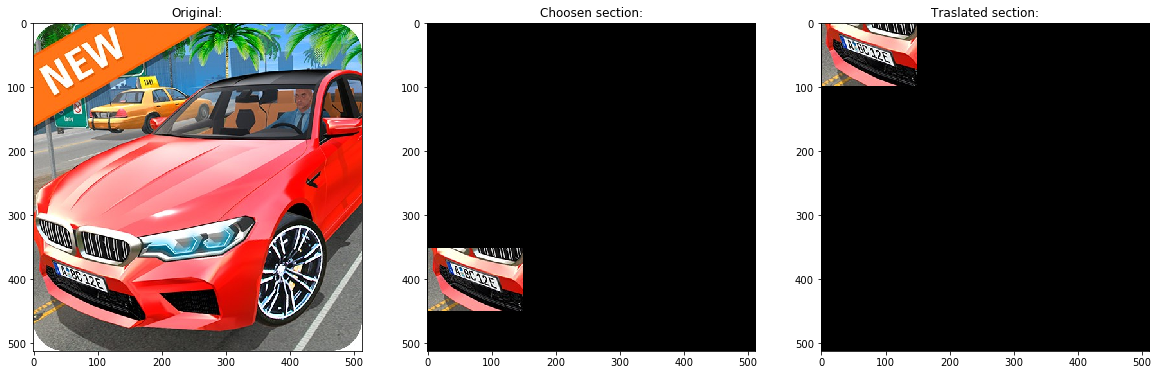

In [7]:
#TEST PARTIAL_TRANSLATE
I_section_traslate=partial_translate(I_sectioned, 350,450,0,150, [-350,0]) #PORTO L'IMMAGINE IN ALTO A SINISTRA

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Original:')
plt.subplot(132)
plt.imshow(I_sectioned)
plt.title('Choosen section:')
plt.subplot(133)
plt.imshow(I_section_traslate)
plt.title('Traslated section:')

Infine partial_zoom effettua lo scaling della porzione scelta, dopo la traslazione.

In [8]:
def partial_zoom(image, x1,x2,y1,y2, zoom_grade):
    width,height=image.shape[:2]    
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u*zoom_grade
            y = v*zoom_grade
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

Text(0.5, 1.0, 'Zoomed section:')

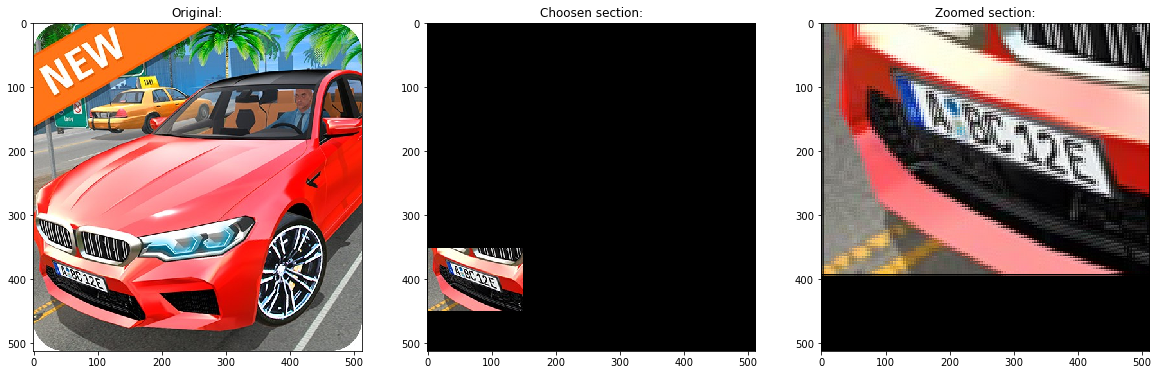

In [9]:
#TEST PARTIAL_ZOOM
I_zoomed=partial_zoom(I_section_traslate, 0,100,0,100, 0.25)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Original:')

plt.subplot(132)
plt.imshow(I_sectioned)
plt.title('Choosen section:')

plt.subplot(133)
plt.imshow(I_zoomed)
plt.title('Zoomed section:')

La concatenazione avverrà invece attraverso il passaggio sequenziale delle immagini campionate tramite mapping inverso, quindi invece di avere un "return dst" finale avremo un passaggio di questa dst alla porzione successiva, che a sua volta produrrà una nuova immagine.
Si può notare un leggero aumento di sgranatura tra l'immagine ingrandita tramite tre funzioni differenti e la stessa ingrandita tramite singola funzione; ciò potrebbe essere dovuto al tipo di mapping utilizzato e alla concatenazione, che probabilmente porta ad una perdita di informazioni.

In [10]:
def zoom(image,x1,x2,y1,y2,zoom_grade):
    width,height=image.shape[:2] 
    
    #Prendo solo la porzione richiesta
    dst1 = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u
            y = v
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if x1 < x < x2 and y1 < y < y2:
                dst1[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    
    #Sposto la porzione scelta nell'angolo in alto a sinistra
    dst2 = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u-(-x1)
            y = v-(-y1)
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst2[u, v] = fracx*fracy*dst1[intx, inty]+(1-fracx)*fracy*dst1[intx+1, inty]+fracx*(1-fracy)*dst1[intx, inty+1]+(1-fracx)*(1-fracy)*dst1[intx+1, inty+1]
    
    #Zoomo la porzione scelta    
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u*zoom_grade
            y = v*zoom_grade
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*dst2[intx, inty]+(1-fracx)*fracy*dst2[intx+1, inty]+fracx*(1-fracy)*dst2[intx, inty+1]+(1-fracx)*(1-fracy)*dst2[intx+1, inty+1]
    return dst

Text(0.5, 1.0, 'Zoomed section:')

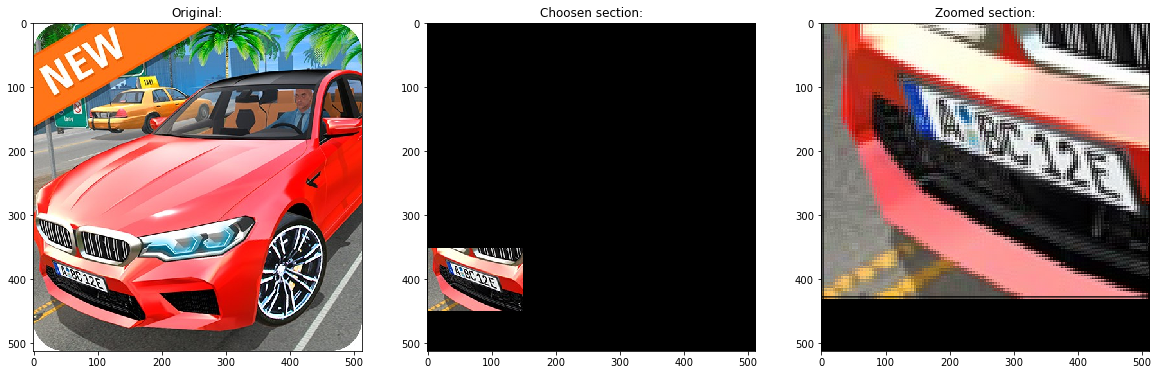

In [11]:
#TEST ZOOM COMPOSTO
I_composite_zoom=zoom(img, 350,450,0,150, 0.23)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Original:')

plt.subplot(132)
plt.imshow(I_sectioned)
plt.title('Choosen section:')

plt.subplot(133)
plt.imshow(I_composite_zoom)
plt.title('Zoomed section:')

## *PROIEZIONE*

A questo punto è facile notare come l'immagine sia si ingrandita ma risulti ancora distorta, e quindi  meno comprensibile. 

E' quindi il momento di applicare una proiezione.
La mia funzione effettua uno "stretch" dell'immagine, chiamato "shear", servendosi di un fattore dato. La particolarità della funzione è il fatto che essa mette in "relazione" i due valori delle direttrici di ogni singolo pixel analizzato, portando ad una trasformazione "omogenea" dell'immagine.
Questa trasformazione può essere fatta sia su una delle due direttrici sia su entrambe.
La scelta del metodo da applicare è importante, infatti molto spesso può bastare anche solo una proiezione su x o y, mentre quando l'immagine risulta "distorta" su entrambe le direttrici, come in questo primo caso, è più sensato utilizzare la doppia proiezione.

Di seguito mostro tutte le varianti:


In [12]:
#SHEAR SU X
def proiezione_x(image, factor):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u + v*factor
            y = v 
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

In [13]:
#SHEAR SU Y
def proiezione_y(image, factor):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u 
            y = v + u*factor
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

In [14]:
#SHEAR SU ENTRAMBE LE DIRETTRICI
def proiezione_totale(image, factor):
    width,height=image.shape[:2]   
    dst = np.zeros((width, height, 3), dtype=np.uint8)
    for u in range(width):
        for v in range(height):
            
            x = u + v*factor
            y = v + u*factor
            
            intx, inty = int(x), int(y)
            # bilinear interpolation
            fracx, fracy = x%1, y%1
            if 0 < x < width-1 and 0 < y < height-1:
                dst[u, v] = fracx*fracy*image[intx, inty]+(1-fracx)*fracy*image[intx+1, inty]+fracx*(1-fracy)*image[intx, inty+1]+(1-fracx)*(1-fracy)*image[intx+1, inty+1]
    return dst

Text(0.5, 1.0, 'Single projected section:')

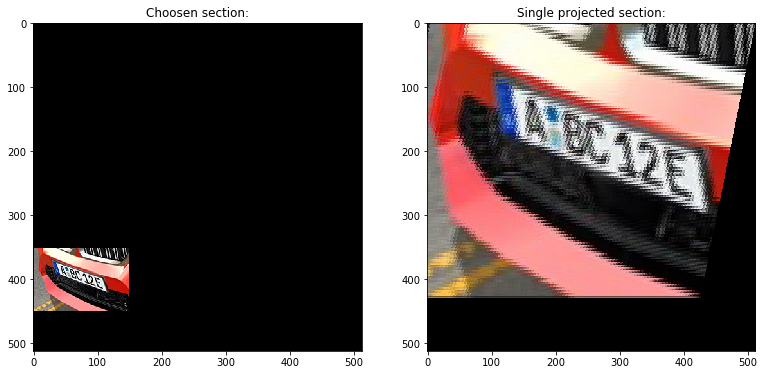

In [15]:
I_projective=proiezione_y(I_composite_zoom, 0.2)

plt.figure(figsize=(20,10))

plt.subplot(132)
plt.imshow(I_sectioned)
plt.title('Choosen section:')

plt.subplot(133)
plt.imshow(I_projective)
plt.title('Single projected section:')

Text(0.5, 1.0, 'Double projected section:')

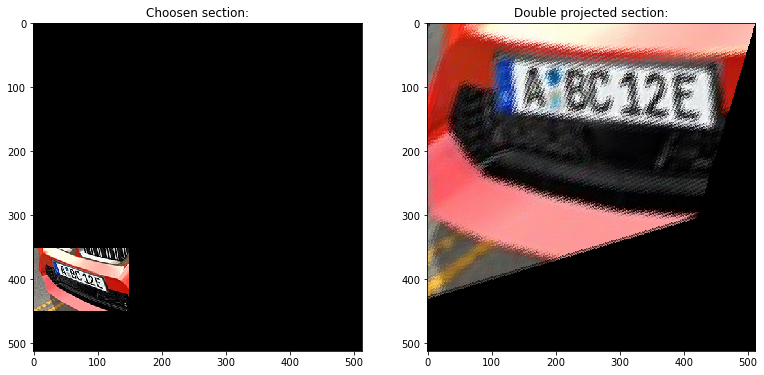

In [16]:
I_projected = proiezione_totale(I_composite_zoom, 0.3)

plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(I_sectioned)
plt.title('Choosen section:')

plt.subplot(132)
plt.imshow(I_projected)
plt.title('Double projected section:')

## ANALISI SPERIMENTALE

Vediamo adesso diversi esempi, nei quali sarà necessario cambiare tipo di proiezione.
Inoltre vedremo il confronto con la proiezione tramite la lbreria OpenCV2; verrà confrontata la proiezione migliore ottenuta.

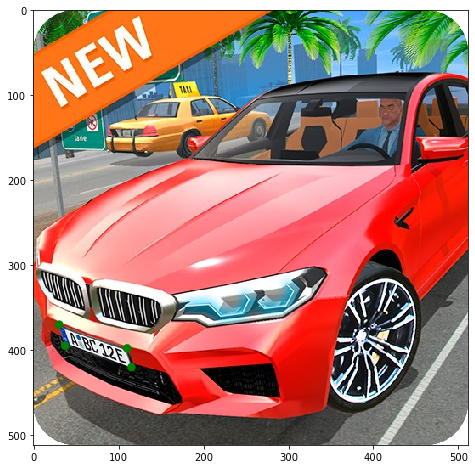

In [17]:
#DEFINIAMO AREA DA PROIETTARE DALLA FOTO ORIGINALE
pt_A = [30, 370]
pt_B = [37, 395]
pt_C = [115, 420]
pt_D = [110, 398]
points_of_interest =[pt_A, pt_B, pt_C, pt_D]

color = 'green'
patch1 = Circle((points_of_interest[0][0],points_of_interest[0][1]),
                 5, facecolor = color)
patch2 = Circle((points_of_interest[1][0],points_of_interest[1][1]), 
                 5, facecolor = color)
patch3 = Circle((points_of_interest[2][0],points_of_interest[2][1]),
                 5, facecolor = color)
patch4 = Circle((points_of_interest[3][0],points_of_interest[3][1]), 
                 5, facecolor = color)

fig, ax = plt.subplots(figsize=(16,8))
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.add_patch(patch3)
ax.add_patch(patch4)

ax.imshow(img);

In [18]:
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))

height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])

output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

transformation = cv2.getPerspectiveTransform(input_pts,output_pts)
projected_plate = cv2.warpPerspective(img,transformation,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

Text(0.5, 1.0, 'Plate projected with my function:')

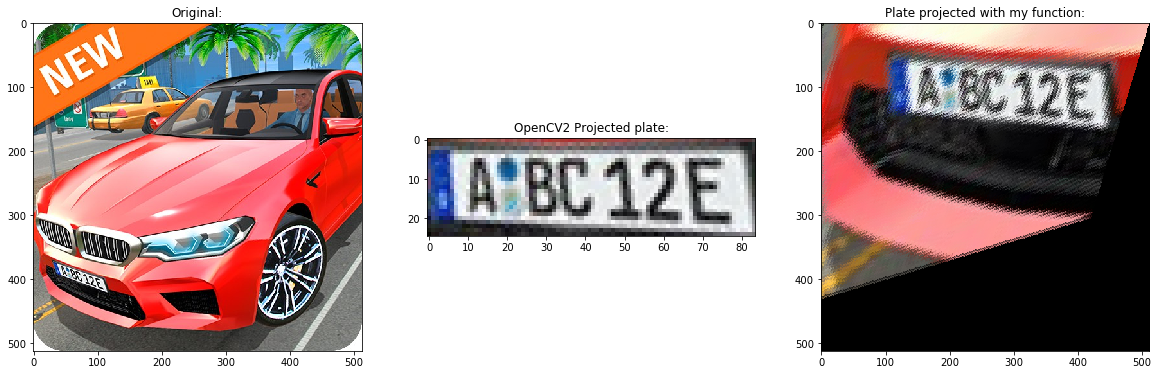

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.title('Original:')

plt.subplot(132)
plt.imshow(projected_plate)
plt.title('OpenCV2 Projected plate:')

plt.subplot(133)
plt.imshow(I_projected)
plt.title('Plate projected with my function:')

(-0.5, 1199.5, 899.5, -0.5)

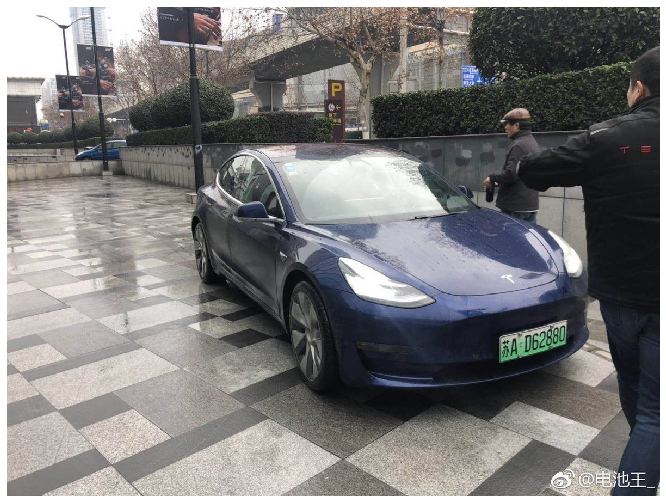

In [20]:
#LOAD IMAGE
img = plt.imread('images/car2.jpg')

plt.figure(figsize=(18,9))
plt.imshow(img); 
plt.axis('off')

Text(0.5, 1.0, 'Projected section:')

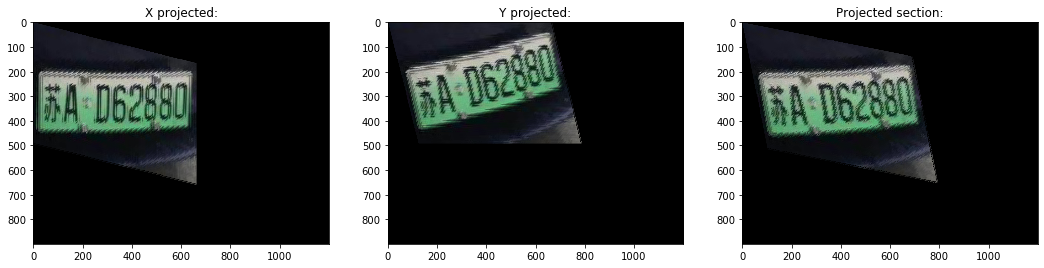

In [21]:
#ZOOM COMPOSTO
I_composite_zoom=zoom(img, 565,665,898,1032, 0.2)

#PROIEZIONE
I_projective1 = proiezione_x(I_composite_zoom, -0.25)
I_projective2 = proiezione_y(I_composite_zoom, -0.25)
I_projected = proiezione_totale(I_composite_zoom, -0.2)

plt.figure(figsize=(18,9))

plt.subplot(131)
plt.imshow(I_projective1)
plt.title('X projected:')

plt.subplot(132)
plt.imshow(I_projective2)
plt.title('Y projected:')

plt.subplot(133)
plt.imshow(I_projected)
plt.title('Projected section:')

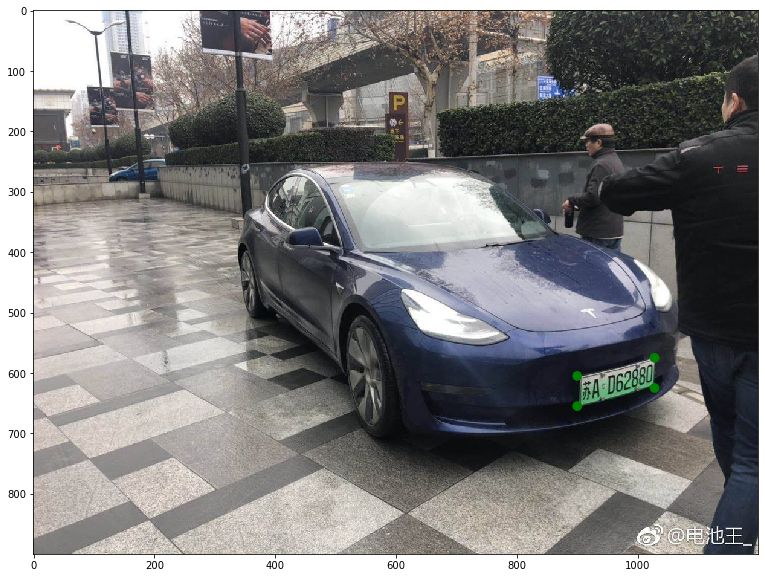

In [22]:
#DEFINIAMO AREA DA PROIETTARE DALLA FOTO ORIGINALE
pt_A = [900, 605]
pt_B = [900, 655]
pt_C = [1028, 625]
pt_D = [1028, 575]
points_of_interest =[pt_A, pt_B, pt_C, pt_D]

color = 'green'
patch1 = Circle((points_of_interest[0][0],points_of_interest[0][1]),
                 8, facecolor = color)
patch2 = Circle((points_of_interest[1][0],points_of_interest[1][1]), 
                 8, facecolor = color)
patch3 = Circle((points_of_interest[2][0],points_of_interest[2][1]),
                 8, facecolor = color)
patch4 = Circle((points_of_interest[3][0],points_of_interest[3][1]), 
                 8, facecolor = color)

fig, ax = plt.subplots(figsize=(15, 10))
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.add_patch(patch3)
ax.add_patch(patch4)

ax.imshow(img);

In [23]:
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))

height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])

output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

transformation = cv2.getPerspectiveTransform(input_pts,output_pts)
projected_plate = cv2.warpPerspective(img,transformation,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

Text(0.5, 1.0, 'X projection:')

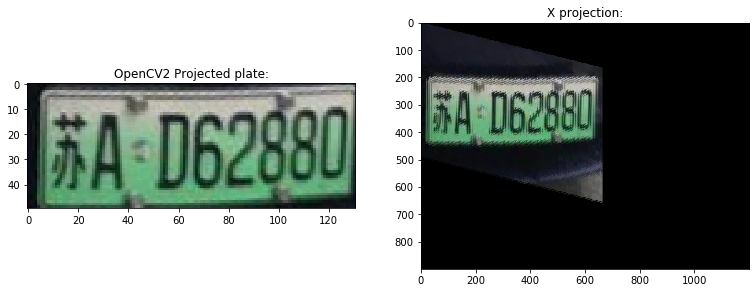

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(projected_plate)
plt.title('OpenCV2 Projected plate:')

plt.subplot(132)
plt.imshow(I_projective1)
plt.title('X projection:')

Mentre nel primo caso ho utilizzato la proiezione su entrambe le direttrici, in questo caso la proiezione più efficace risulta essere quella che agisce sull'asse x, in quanto la targa dell'immagine risulta distorta solo in lungo, mentre la prima immagine presentava anche una leggera inclinatura in avanti.


(-0.5, 1023.5, 635.5, -0.5)

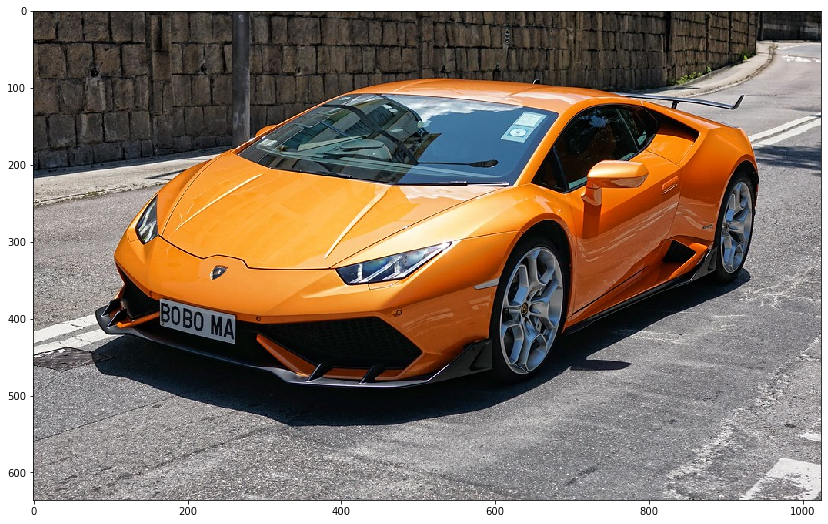

In [25]:
#LOAD IMAGE
img = plt.imread('images/car3.jpg')

plt.figure(figsize=(18,9))
plt.imshow(img); 
plt.axis('on')

Text(0.5, 1.0, 'Double projected section:')

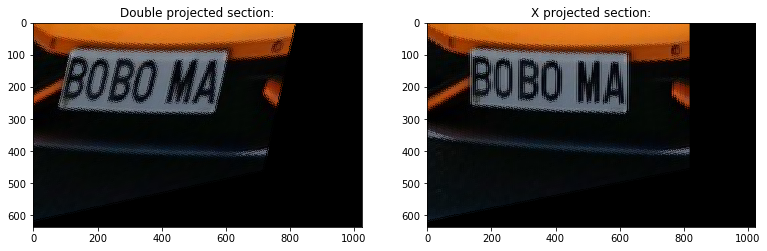

In [26]:
#ZOOM COMPOSTO
I_composite_zoom=zoom(img, 350,475,135,300, 0.2)

#PROIEZIONE 
I_projective = proiezione_x(I_composite_zoom, 0.2)
I_projected = proiezione_totale(I_composite_zoom, 0.22)

plt.figure(figsize=(20,10))

plt.subplot(132)
plt.imshow(I_projective)
plt.title('X projected section:')

plt.subplot(131)
plt.imshow(I_projected)
plt.title('Double projected section:')

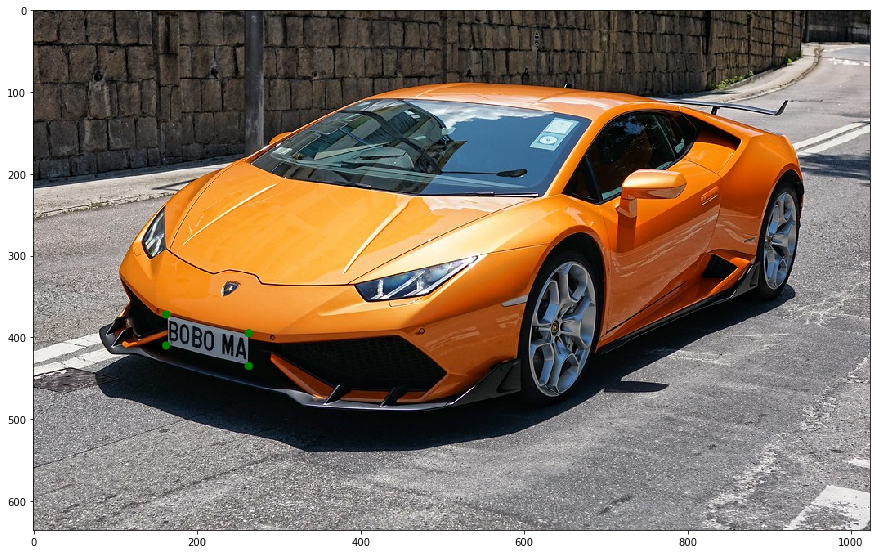

In [27]:
#DEFINIAMO AREA DA PROIETTARE DALLA FOTO ORIGINALE
pt_A = [162, 372]
pt_B = [162, 410]
pt_C = [263, 435]
pt_D = [263, 395]
points_of_interest =[pt_A, pt_B, pt_C, pt_D]

color = 'green'
patch1 = Circle((points_of_interest[0][0],points_of_interest[0][1]),
                 5, facecolor = color)
patch2 = Circle((points_of_interest[1][0],points_of_interest[1][1]), 
                 5, facecolor = color)
patch3 = Circle((points_of_interest[2][0],points_of_interest[2][1]),
                 5, facecolor = color)
patch4 = Circle((points_of_interest[3][0],points_of_interest[3][1]), 
                 5, facecolor = color)

fig, ax = plt.subplots(figsize=(15, 10))
ax.add_patch(patch1)
ax.add_patch(patch2)
ax.add_patch(patch3)
ax.add_patch(patch4)

ax.imshow(img);

In [28]:
width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))

height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])

output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

transformation = cv2.getPerspectiveTransform(input_pts,output_pts)
projected_plate = cv2.warpPerspective(img,transformation,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)

Text(0.5, 1.0, 'X projection:')

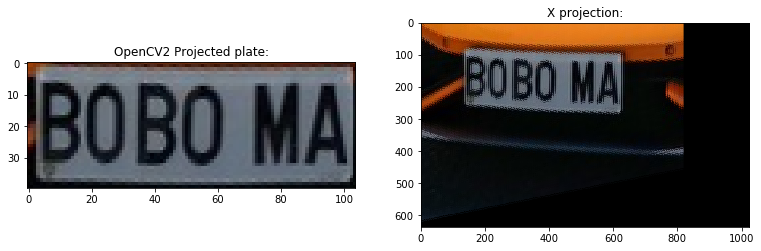

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(projected_plate)
plt.title('OpenCV2 Projected plate:')

plt.subplot(132)
plt.imshow(I_projective)
plt.title('X projection:')

## CONCLUSIONI

Come si può vedere la proiezione di OpenCV2 risulta avere una qualità migliore rispetto alla mia, oltre ad avere una dimensione adattata alla porzione proiettata; questo come già accennato potrebbe essere riconducibile in un primo momento alla concatenazione dei mapping inversi, possibile causa di perdita di informazioni.

Nelle immagini utilizzate abbiamo utilizzato sia la doppia proiezione sia la proiezione su x; la doppia proiezione si è resa necessaria nella prima immagine poichè la targa risulta distorta su entrambe le direttrici, essendo infatti leggermente "inclinata" in avanti e distorta per via del punto di vista.
Le altre due immagini invece risultano molto più "dritte", per cui non è necessario agire sulla direttrice y.
Avrei voluto trovare un caso in cui la proiezione sull'asse Y fosse la più funzionale, ma non ho trovato immagini adeguate allo scopo, e le stesse immagini utilizzate non risultano adatte a questo tipo di proiezione.

### _Fonti:_
- https://www.cs.princeton.edu/courses/archive/spring21/cos426/lectures/Lecture-2.pdf